### P1: Summarization
### P2: Sentiment Analysis
### P3: Event Extraction and Visualization (NER, spacy)
### p4: Translation


In [1]:
import re
import docx 
import os
import PyPDF2
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from textblob import TextBlob
from translate import Translator
import spacy
import matplotlib.pyplot as plt
import requests 


### Using normal Text

In [2]:
# Input text - to summarize
text = " There are many techniques available to generate extractive summarization to keep it simple, I will be using an unsupervised learning approach to find the sentences similarity and rank them. Summarization can be defined as a task of producing a concise and fluent summary while preserving key information and overall meaning. One benefit of this will be, you don’t need to train and build a model prior start using it for your project. It’s good to understand Cosine similarity to make the best use of the code you are going to see. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Its measures cosine of the angle between vectors. The angle will be 0 if sentences are similar.  "

In [48]:
file_path = 'test.txt' 

with open(file_path, 'r') as file:
    text = file.read()

### Using URL

In [ ]:
# Input URL - to fetch and summarize
url = "https://en.wikipedia.org/wiki/Napoleon"  # Replace with the URL you want to summarize

# Fetch content from the URL
response = requests.get(url)
text = response.text

### Using docx

In [ ]:
# Specify the file path
file_path = 'short-history-world.docx'  # Replace 'your_file.txt' with the actual file path

# Read the contents of the file
doc = docx.Document(file_path)
text = ""

for paragraph in doc.paragraphs:
    text += paragraph.text + "\n"

### Using PDF

In [2]:
# Extract text from PDF
file_path = 'short-history-world.pdf'
start_page = 5
end_page = 139

def extract_text_from_pdf(file_path, start_page, end_page):
    pdf_file = open(file_path, 'rb')        # Open the PDF file for reading in binary mode ('rb')
    pdf_reader = PyPDF2.PdfReader(pdf_file) # Create a PDF reader object
    text = ""
    for page_num in range(start_page - 1, end_page - 1):
        page = pdf_reader.pages[page_num]
        text += page.extract_text()
    pdf_file.close()
    return text

text = extract_text_from_pdf(file_path, start_page, end_page)


### Cleaning text 

In [3]:
def clean_text(text):
    # Keeping only alpha numeric characters and (, .)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.,]', '', text)
    return cleaned_text

cleaned_text = clean_text(text)

### Tokenize and preprocess the text

In [4]:
def tokenize_and_preprocess_text(text):
    sentences = sent_tokenize(text) # Tokenize the text into sentences

    stop_words = set(stopwords.words('english')) # Get a set of English stopwords
    word_frequencies = {} # Initialize a dictionary to store word frequencies
    for sentence in sentences:
        words = word_tokenize(sentence) # Tokenize each sentence into words
        # Lowercase words, remove non-alphanumeric characters, and filter out stopwords
        words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]
        fdist = FreqDist(words) # Calculate word frequencies in the current sentence
        for word, freq in fdist.items():
            if word in word_frequencies:
                word_frequencies[word] += freq
            else:
                word_frequencies[word] = freq
    
    return sentences, word_frequencies # Return tokenized sentences and word frequencies

sentences, word_frequencies = tokenize_and_preprocess_text(cleaned_text)

### Rank sentences by frequency

In [5]:
def rank_sentences_by_frequency(sentences, word_frequencies):
    sentence_scores = {}  # Initialize a dictionary to store sentence scores
    for sentence in sentences:  
        words = word_tokenize(sentence)  # Tokenize the current sentence into words
        for word in words: 
            if word in word_frequencies:  # Check if the word exists in the word_frequencies dictionary
                if sentence in sentence_scores:  # Check if the sentence is already in sentence_scores
                    sentence_scores[sentence] += word_frequencies[word]  # Add the word frequency to the sentence score
                else:
                    sentence_scores[sentence] = word_frequencies[word]  # Initialize the sentence score with the word frequency
    return sentence_scores  

# Rank sentences by word frequency
sentence_scores = rank_sentences_by_frequency(sentences, word_frequencies)  
print(sentence_scores)

{'The British Empire in 1914 \nLXV.': 5, 'The Age of Armament in Europe, and the Great War of 191418 \nLXVI.': 4, 'The World in Space\nTHE STORY of our world is a story that is still very imperfectly known.': 713, 'A couple of hundred years ago men\npossessed the history of little more than the last three thousand years.': 1166, 'What happened before that time was a\nmatter of legend and speculation.': 244, 'Over a large part of the civilized world it was believed and taught that the world\nhad been created suddenly in 4004 B.C., though authorities differed as to whether this had occurred in the spring\nor autumn of that year.': 1240, 'This fantastically precise misconception was based upon a too literal interpretation of the\nHebrew Bible, and upon rather arbitrary theological assumptions connected therewith.': 644, 'Such ideas have long since\nbeen abandoned by religious teachers, and it is universally recognized that the universe in which we live has to all\nappearances existed for 

### Calculate the average sentence score

In [6]:
total_score = sum(sentence_scores.values())
average_score = total_score / len(sentence_scores)

print("Sentences:", sentences)
print("Sentence Scores:", sentence_scores)
print("Average Score:", average_score)
print (len(text))

Sentences: ['XLIII.', 'Muhammad and Islam \nXLIV.', 'The Great Days of the Arabs \nXLV.', 'The Development of Latin Christendom \nXLVI.', 'The Crusades and the Age of Papal Dominion \nXLVII.', 'Recalcitrant Princes and the Great Schism \nXLVIII.', 'The Mongol Conquests \nXLIX.', 'The Intellectual Revival of the Europeans \nL. The Reformation of the Latin Church \nLI.', 'The Emperor Charles V \nLII.', 'The Age of Political Experiments of Grand Monarchy and Parliaments and Republicanism in Europe \nLIII.', 'The New Empires of the Europeans in Asia and Overseas \nLIV.', 'The American War of Independence \nLV.', 'The French Revolution and the Restoration of Monarchy in France \nLVI.', 'The Uneasy Peace in Europe That Followed the Fall of Napoleon \nLVII.', 'The Development of Material Knowledge \nLVIII.', 'The Industrial Revolution \nLIX.', 'The Development of Modern Political and Social Ideas \nLX.', 'The Expansion of the United States \nLXI.', 'The Rise of Germany to Predominance in Euro

### Summarize text

In [12]:
def generate_summary(sentences, sentence_scores, average_score):
    # Create an initial summary by selecting sentences with scores above the average
    summary = [sentence for sentence in sentences if sentence in sentence_scores and sentence_scores[sentence] > average_score]
    final_summary = ' '.join(summary)  # Join the selected sentences to form the final summary
    return final_summary


final_summary = generate_summary(sentences, sentence_scores, average_score)

# Save the final summary to a TXT file
with open('Summary of '+os.path.basename(file_path)+'.txt', 'w', encoding='utf-8') as file:
    file.write(final_summary)  
    
# Calculate the summarized percentage
original_text_length = len(text)
summary_length = len(final_summary)
summarized_percentage = (summary_length / original_text_length) * 100
print(f"Summarized Percentage: {summarized_percentage:.2f}%")

Summarized Percentage: 53.10%


### Summarize text to a certain percentage 

Using the previous code

In [13]:
def generate_summary(sentences, sentence_scores, average_score):
    # Create an initial summary by selecting sentences with scores above the average
    summary = [sentence for sentence in sentences if sentence in sentence_scores and sentence_scores[sentence] > 1.3 * average_score]
    final_summary = ' '.join(summary)  # Join the selected sentences to form the final summary
    return final_summary


final_summary = generate_summary(sentences, sentence_scores, average_score)

# Save the final summary to a TXT file
with open('Summary of '+os.path.basename(file_path)+'.txt', 'w', encoding='utf-8') as file:
    file.write(final_summary)  
    
# Calculate the summarized percentage
original_text_length = len(text)
summary_length = len(final_summary)
summarized_percentage = (summary_length / original_text_length) * 100
print(f"Summarized Percentage: {summarized_percentage:.2f}%")

Summarized Percentage: 41.25%


Another method

In [14]:
from collections import Counter

def generate_summary_percentage(sentences, sentence_scores, target_percentage):
    # Calculate the number of sentences to be included in the summary
    total_sentences = len(sentences)
    sentences_to_include = int(total_sentences * target_percentage)

    # Create a Counter object to track the order and score of each sentence
    sentence_order_and_score = Counter()

    for sentence in sentences:
        score = sentence_scores.get(sentence, 0)
        sentence_order_and_score[sentence] = score

    # Select the top 'sentences_to_include' sentences while maintaining order
    selected_sentences = sentence_order_and_score.most_common(sentences_to_include)

    # Sort the selected sentences based on their original order
    selected_sentences = sorted(selected_sentences, key=lambda item: sentences.index(item[0]))

    # Extract the selected sentences in order
    final_Psummary = ' '.join(sentence for sentence, _ in selected_sentences)

    return final_Psummary

# Usage remains the same
target_percentage = 0.2  # Specify the target percentage for the summary

final_Psummary = generate_summary_percentage(sentences, sentence_scores, target_percentage)

# Save the final summary to a TXT file
with open('Percentage Summary of ' + os.path.basename(file_path) + '.txt', 'w', encoding='utf-8') as file:
    file.write(final_Psummary)

# Calculate the summarized percentage
original_text_length = len(text)
summary_length = len(final_Psummary)
summarized_percentage = (summary_length / original_text_length) * 100
print(f"Summarized Percentage: {summarized_percentage:.2f}%")


Summarized Percentage: 32.42%


### Sentiment Analysis

In [15]:
def sentiment_analysis(text):
    sentiment_scores = []  # Initialize a list to store sentiment scores
    
    for sentence in text:
        blob = TextBlob(sentence)  # Create a TextBlob object for the current sentence
        sentiment = blob.sentiment  # Perform sentiment analysis on the sentence
        sentiment_scores.append(sentiment)  # Append the sentiment score to the list
    
    # Calculate the average polarity by summing up the polarities and dividing by the number of scores
    average_polarity = sum(score.polarity for score in sentiment_scores) / len(sentiment_scores)
    
    return average_polarity  



# Sentiment Analysis
average_polarity = sentiment_analysis(sentences)
sentiment_threshold = 0.1
if average_polarity > sentiment_threshold:
    sentiment_label = "Positive"
elif average_polarity < -sentiment_threshold:
    sentiment_label = "Negative"
else:
    sentiment_label = "Neutral"
print("Sentiment Analysis Results:")
print(f"Average Polarity: {average_polarity:.2f}")
print(f"Sentiment Label: {sentiment_label}")

Sentiment Analysis Results:
Average Polarity: 0.09
Sentiment Label: Neutral


### Event Extraction and Visualization (Named entity recognition NER)

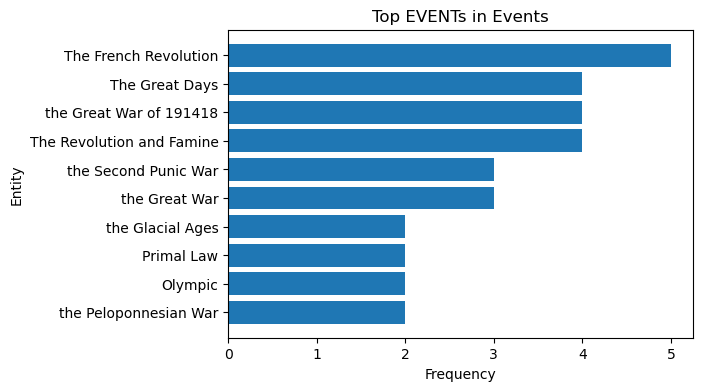

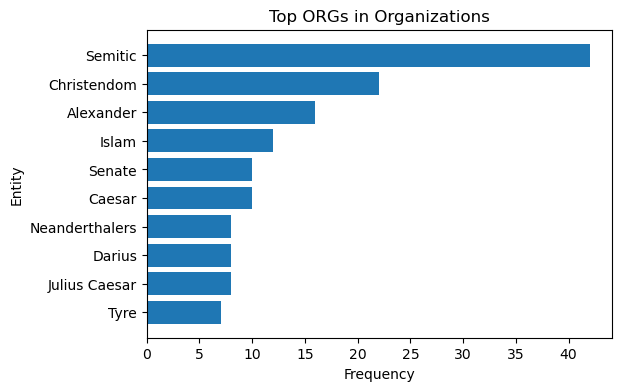

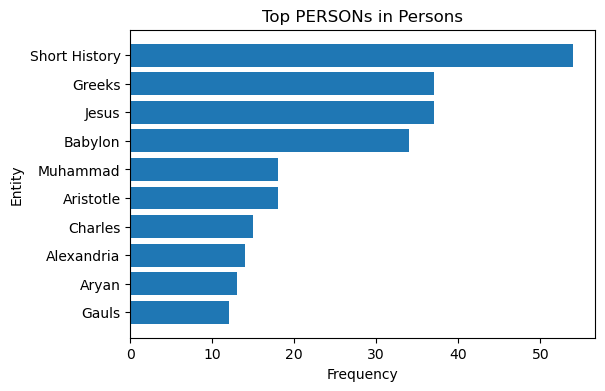

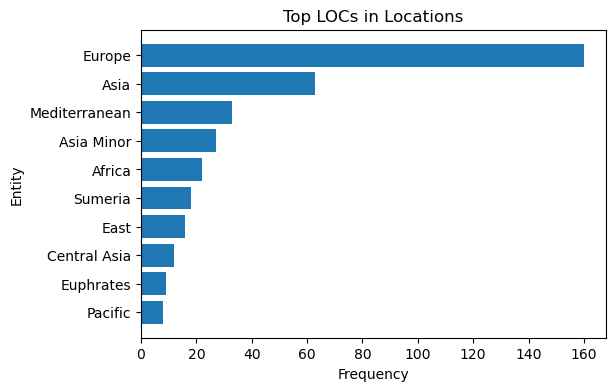

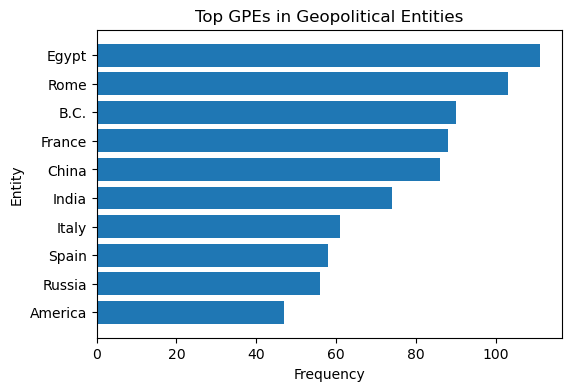

In [16]:
def extract_and_visualize_entities(text, entity_type, title):
    nlp = spacy.load("en_core_web_sm")  # Load the English language model in spaCy
    chunk_size = 100000 
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]  # Split the text into smaller chunks
    entities = []  # Initialize a list to store identified entities
    
    for chunk in chunks:
        doc = nlp(chunk)  # Process each chunk with spaCy to extract entities
        for ent in doc.ents:
            if ent.label_ == entity_type:
                entities.append(ent.text)  # Append identified entities of the specified type
    
    entity_frequencies = FreqDist(entities)  # Calculate the frequency distribution of identified entities
    N = 10  # Define the number of top entities to display
    top_entities = entity_frequencies.most_common(N)  # Get the most common entities
    entity_labels, entity_counts = zip(*top_entities)  # Separate labels and counts
    
    plt.figure(figsize=(6, 4))
    plt.barh(entity_labels, entity_counts)
    plt.xlabel('Frequency')
    plt.ylabel('Entity')
    plt.title(f'Top {entity_type}s in {title}') 
    plt.gca().invert_yaxis()  
    plt.show()  



# Entity Recognition
topics = {
    "Events": "EVENT",
    "Organizations": "ORG",
    "Persons": "PERSON",
    "Locations": "LOC",
    "Geopolitical Entities": "GPE",
}
nlp = spacy.load("en_core_web_sm")
for topic, entity_type in topics.items():
    extract_and_visualize_entities(cleaned_text, entity_type, topic)    


### Translation


In [17]:
def translate_text(text, target_language='fr'):
    # Split the input text into segments of 500 characters each
    segments = [text[i:i + 500] for i in range(0, len(text), 500)]

    # Create a Translator object with the target language specified
    translator = Translator(to_lang=target_language)

    translated_segments = []  # Initialize a list to store translated segments

    # Iterate through each segment and translate it
    for segment in segments:
        translation = translator.translate(segment)  # Perform translation on the segment
        translated_segments.append(translation)  # Append the translated segment to the list

    # Join the translated segments to form the final translated text
    translated_text = ' '.join(translated_segments)

    return translated_text  # Return the translated text as a string

# Translation
translated_summary = translate_text(final_summary, target_language='fr')

# Save the translated summary to a file
with open('Translated '+os.path.basename(file_path)+'.txt', 'w', encoding='utf-8') as file:
    file.write(translated_summary)

 

print("Translated Summary (French) saved to: translated_summary.txt")


Translated Summary (French) saved to: translated_summary.txt


### Sentiment analysis

In [18]:
import pandas as pd

# Create a DataFrame from your Excel file
data = pd.read_excel("data_for_use.xlsx")
# Drop rows with NaN values in any column
data.dropna(inplace=True)
data.head(5)


,Title,Review,State,Price
0,R Made Easy,Excellent,TX,19.99
1,R For Dummies,Poor,NY,15.99
2,R Made Easy,Excellent,NY,19.99
3,R Made Easy,Poor,FL,19.99
4,Secrets Of R For Advanced Students,Great,Texas,50.00


In [19]:


# Define a function to assign weighted values to sentiments
def assign_weighted_value(review):
    if review == "Excellent":
        return 5  # Assign the highest value for "Excellent"
    elif review == "Great":
        return 4  # Assign a high value for "Great"
    elif review == "Good":
        return 3  # Assign a moderate value for "Good"
    elif review == "Fair":
        return 2  # Assign a neutral value for "Fair"
    elif review == "Poor":
        return 1  # Assign a negative value for "Poor"
    else:
        return 0  # Assign a neutral value for any other sentiment or "NaN"

# Apply the weighted sentiment assignment to the "Review" column
data["Weighted Sentiment"] = data["Review"].apply(assign_weighted_value)

# Group the data by "Title" and calculate the weighted sentiment score for each book
book_sentiment_counts = data.groupby("Title")["Weighted Sentiment"].count()
book_weighted_sentiment_sum = data.groupby("Title")["Weighted Sentiment"].sum()

# Calculate the weighted average sentiment for each book
book_weighted_average_sentiment = book_weighted_sentiment_sum / book_sentiment_counts

# Define a function to map the weighted average sentiment to ratings
def map_to_rating(weighted_sentiment):
    if weighted_sentiment >= 4.5:
        return "Excellent"
    elif weighted_sentiment >= 3.5:
        return "Great"
    elif weighted_sentiment >= 2.5:
        return "Good"
    elif weighted_sentiment >= 1.5:
        return "Fair"
    else:
        return "Poor"

# Apply the rating assignment to the weighted average sentiment
book_ratings = book_weighted_average_sentiment.apply(map_to_rating)

# Display the ratings for each book
print(book_ratings)


Title
Fundamentals of R For Beginners       Good
R For Dummies                         Poor
R Made Easy                           Good
Secrets Of R For Advanced Students    Good
Top 10 Mistakes R Beginners Make      Good
Name: Weighted Sentiment, dtype: object
